In [1]:
!nvidia-smi

Tue Aug  4 22:32:10 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
%tensorflow_version 1.x
import tensorflow as tf
print((tf.__version__))

import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

TensorFlow 1.x selected.
1.15.2


*importing needed libraries.* 

In [3]:

from keras.datasets import cifar10
from keras.models import Sequential, Model
from keras.layers import Dense, LeakyReLU, BatchNormalization
from keras.layers import Conv2D, Conv2DTranspose, Reshape, Flatten
from keras.layers import Input, Flatten, Embedding, multiply, Dropout
from keras.layers import Concatenate, GaussianNoise,Activation
from keras.optimizers import Adam
from keras.utils import np_utils, to_categorical
from keras import initializers
from keras import backend as K

Using TensorFlow backend.


loading both train data and test data with their labels.

In [4]:
# load dataset
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

number of classes is 10, class_names is a dic of all names, here we want to show one hundred pics of cifar10. figsize is use for the size of the picture shown, np.where searches for an image which has the label 'i'. features_idx is all the images which have the 'i' label, then we pick a random image in all these co_labeled images. then we plot it. plt.tight_layout() produces enough spacing between pics.

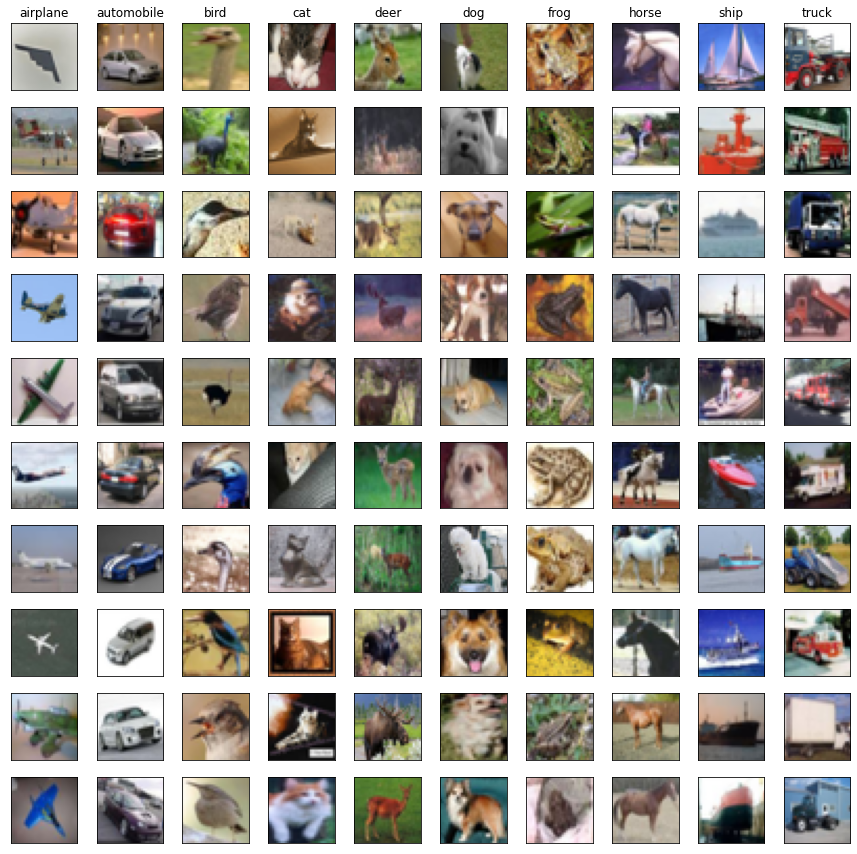

In [5]:
num_classes = len(np.unique(y_train))
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

fig = plt.figure(figsize=(12,12))
for i in range(num_classes):
  for j in range(num_classes):
    x = plt.subplot(10, 10, 1 + i + 10*j, xticks=[], yticks=[])
    idx = np.where(y_train[:]==i)[0]
    features_idx = X_train[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    img = features_idx[img_num,::]
    if j==0:
      x.set_title(class_names[i])
    plt.imshow(img)
    
plt.tight_layout()

In [6]:
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

X_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


if the keras backend image data format is channel first we reshape our images, but it is not! so whatever the shape is we reshape it to (n,32,32,3).
to_categorical changes the labels into a matrix of one hot vectors corresponding that label. then we normalize our data associating with tanh (-1,1).

In [7]:
if K.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 3, 32, 32)
    X_test = X_test.reshape(X_test.shape[0], 3, 32, 32)
    input_shape = (3, 32, 32)
else:
    X_train = X_train.reshape(X_train.shape[0], 32, 32, 3)
    X_test = X_test.reshape(X_test.shape[0], 32, 32, 3)
    input_shape = (32, 32, 3)
    
# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, num_classes)
Y_test = np_utils.to_categorical(y_test, num_classes)

# the generator is using tanh activation, for which we need to preprocess 
# the image data into the range between -1 and 1.

X_train = np.float32(X_train)
X_train = (X_train / 255 - 0.5) * 2
X_train = np.clip(X_train, -1, 1)

X_test = np.float32(X_test)
X_test = (X_test / 255 - 0.5) * 2
X_test = np.clip(X_test, -1, 1)

print('X_train reshape:', X_train.shape)
print('X_test reshape:', X_test.shape)

X_train reshape: (50000, 32, 32, 3)
X_test reshape: (10000, 32, 32, 3)


In [8]:
print(X_train[0].shape)


(32, 32, 3)


here we define our generator model that has an input layer which is the concatenate of nois and class label.
this goes into a dense layer that has an output size of 128*8*8.
then we reshape this vector so that is stand for the different feature maps( (8,8,128)).
then we use 7 deconve layers. first six have 128 filters and the last one has 3 filters because of the number of layers in an image (rgb). the output is size of (32,32,3) then goes through tanh.
all AFs are leaky relo exept the output layer.
in all layers exept the output layer we use batch normalization.
at the end we build a generator.

In [9]:


z=Input(shape=(100,))

classes_labels=Input(shape=(10,))

merged_input = Concatenate()([z, classes_labels])

hid = Dense(128 * 8 * 8, activation='relu')(merged_input)    
hid = BatchNormalization(momentum=0.9)(hid)
hid = LeakyReLU(alpha=0.1)(hid)
hid = Reshape((8, 8, 128))(hid)

hid = Conv2DTranspose(128, kernel_size=4, strides=1,padding='same')(hid)
hid = BatchNormalization(momentum=0.9)(hid)    
hid = LeakyReLU(alpha=0.1)(hid)

hid = Conv2DTranspose(128, 4, strides=2, padding='same')(hid)
hid = BatchNormalization(momentum=0.9)(hid)
hid = LeakyReLU(alpha=0.1)(hid)

hid = Conv2DTranspose(128, kernel_size=5, strides=1,padding='same')(hid)
hid = BatchNormalization(momentum=0.9)(hid)    
hid = LeakyReLU(alpha=0.1)(hid)

hid = Conv2DTranspose(128, 4, strides=2, padding='same')(hid)
hid = BatchNormalization(momentum=0.9)(hid)
hid = LeakyReLU(alpha=0.1)(hid)

hid = Conv2DTranspose(128, kernel_size=5, strides=1, padding='same')(hid)
hid = BatchNormalization(momentum=0.9)(hid)
hid = LeakyReLU(alpha=0.1)(hid)

hid = Conv2DTranspose(128, kernel_size=5, strides=1, padding='same')(hid)
hid = BatchNormalization(momentum=0.9)(hid)
hid = LeakyReLU(alpha=0.1)(hid)
                  
hid = Conv2DTranspose(3, kernel_size=5, strides=1, padding="same")(hid)
out = Activation("tanh")(hid)

generator = Model(inputs=[z, classes_labels], outputs=out)


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [10]:
# prints a summary representation of your model
generator.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 10)           0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 110)          0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 8192)         909312      concatenate_1[0][0]        

here we build the discriminator. it has 4 conv layers that all have 128 filters. after all conv layers our output has (4,4,128) shape, then we flatten it, conatenate it with the one hot label vector and feed it to a dense layer so that it gets classified.
all AFs are relo exept the last layer that need sigmoid(for targets are 0 and 1)
all layers use batch normalization exept the output layer.

In [12]:

images = Input(shape=(X_train[0].shape))
hid = Conv2D(128, kernel_size=3, strides=1, padding='same')(images)
hid = BatchNormalization(momentum=0.9)(hid)
hid = LeakyReLU(alpha=0.1)(hid)

hid = Conv2D(128, kernel_size=4, strides=2, padding='same')(hid)
hid = BatchNormalization(momentum=0.9)(hid)
hid = LeakyReLU(alpha=0.1)(hid)

hid = Conv2D(128, kernel_size=4, strides=2, padding='same')(hid)
hid = BatchNormalization(momentum=0.9)(hid)
hid = LeakyReLU(alpha=0.1)(hid)

hid = Conv2D(128, kernel_size=4, strides=2, padding='same')(hid)
hid = BatchNormalization(momentum=0.9)(hid)
hid = LeakyReLU(alpha=0.1)(hid)

hid = Flatten()(hid)

merged_layer = Concatenate()([hid, classes_labels])
hid = Dense(512, activation='relu')(merged_layer)
#hid = Dropout(0.4)(hid)
out = Dense(1, activation='sigmoid')(hid)

discriminator = Model(inputs=[images, classes_labels], outputs=out)



In [13]:
# prints a summary representation of your model
discriminator.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 32, 32, 128)  3584        input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_8 (BatchNor (None, 32, 32, 128)  512         conv2d_2[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_8 (LeakyReLU)       (None, 32, 32, 128)  0           batch_normalization_8[0][0]      
____________________________________________________________________________________________

training the discriminator is done by the compile method using adam opt, an binary crossentropy as loss function.

In [14]:
# # Optimizer
discriminator.compile(Adam(lr=0.0002, beta_1=0.5), loss='binary_crossentropy',
                      metrics=['binary_accuracy'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


to train the Gen trainable variables of the dis must be turned off and we must have the full GAN model(d_g) .
so we make our model by using a noise and label as inputs and the output of discriminator for fake_img that is produced by generator as output.
the optimizer is adam and LR is twice the value of disc's LR.

In [15]:
discriminator.trainable = False

label = Input(shape=(10,), name='label')
z = Input(shape=(100,), name='z')

fake_img = generator([z, label])
validity = discriminator([fake_img, label])

d_g = Model([z, label], validity, name='adversarial')

d_g.compile(Adam(lr=0.0004, beta_1=0.5), loss='binary_crossentropy',
            metrics=['binary_accuracy'])

In [16]:

# prints a summary representation of your model
d_g.summary()

Model: "adversarial"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
z (InputLayer)                  (None, 100)          0                                            
__________________________________________________________________________________________________
label (InputLayer)              (None, 10)           0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 32, 32, 3)    2970755     z[0][0]                          
                                                                 label[0][0]                      
__________________________________________________________________________________________________
model_2 (Model)                 (None, 1)            1847169     model_1[1][0]          

in this cell we train our model.
number of epochs is 100, batch size is 32,
smooth is used to reduce the target value of real images.
we make two lists to append the loss values to them.
for each batch first we train the dis and the the Gen.
for the Dis we first train it with a batch of real data. we get the loss. then we make some random noises and one hot labels, feeding them to generator we make our fake data. then we feed it to the Dis by the method: train_on_batch. now Dis has been trained and we have both the real loss and the fake loss.
we calculate the average of the first iteration as an indicator of the whole loss of every epoch.
then we train the Generator by turning the training of disc to false and giving random noise and random label as inputs to the d_g. using the method : train_on_batch.
at the end we generate 10 images each of a single class(by giving the label to Gen). we do this for 10 times to have 100 images. we denormalize the Gen output and we show it.

In [ ]:
epochs = 100
batch_size = 32
smooth = 0.1
latent_dim = 100

real = np.ones(shape=(batch_size, 1))
fake = np.zeros(shape=(batch_size, 1))

d_loss = []
d_g_loss = []

for e in range(epochs + 1):
    for i in range(len(X_train) // batch_size):
        
        # Train Discriminator weights
        discriminator.trainable = True
        
        # Real samples
        X_batch = X_train[i*batch_size:(i+1)*batch_size]
        real_labels = to_categorical(y_train[i*batch_size:(i+1)*batch_size].reshape(-1, 1), num_classes=10)
        
        d_loss_real = discriminator.train_on_batch(x=[X_batch, real_labels],
                                                   y=real * (1 - smooth))
        
        # Fake Samples
        z = np.random.normal(loc=0, scale=1, size=(batch_size, latent_dim))
        random_labels = to_categorical(np.random.randint(0, 10, batch_size).reshape(-1, 1), num_classes=10)
        X_fake = generator.predict_on_batch([z, random_labels])
        
        d_loss_fake = discriminator.train_on_batch(x=[X_fake, random_labels], y=fake)
         
        # Discriminator loss
        d_loss_batch = 0.5 * (d_loss_real[0] + d_loss_fake[0])
        
        # Train Generator weights
        discriminator.trainable = False
        
        z = np.random.normal(loc=0, scale=1, size=(batch_size, latent_dim))
        random_labels = to_categorical(np.random.randint(0, 10, batch_size).reshape(-1, 1), num_classes=10)
        d_g_loss_batch = d_g.train_on_batch(x=[z, random_labels], y=real)
   
        print(
            'epoch = %d/%d, batch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, i, len(X_train) // batch_size, d_loss_batch, d_g_loss_batch[0]),
            100*' ',
            end='\r'
        )
    
    d_loss.append(d_loss_batch)
    d_g_loss.append(d_g_loss_batch[0])
    print('epoch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, d_loss[-1], d_g_loss[-1]), 100*' ')

    if e % 10 == 0:
      for m in range(10): 
        samples = 10
        z = np.random.normal(loc=0, scale=1, size=(samples, latent_dim))
        labels = to_categorical(np.arange(0, 10).reshape(-1, 1), num_classes=10)
        
        x_fake = generator.predict([z, labels])
        x_fake = np.clip(x_fake, -1, 1)
        x_fake = (x_fake + 1) * 127
        x_fake = np.round(x_fake).astype('uint8')
        
        fig = plt.figure(figsize=(14,14))
        for k in range(samples):
            plt.subplot(10, 10, k + 1 + 10*m, xticks=[], yticks=[])
            plt.imshow(x_fake[k])
            if m==0:
              plt.title(class_names[k])

        plt.tight_layout()
        plt.show()

we plot the gen and dis loss function values.

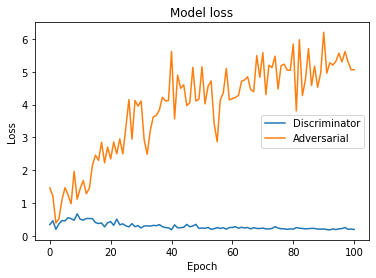

In [18]:

# plotting the metrics
plt.plot(d_loss)
plt.plot(d_g_loss)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Dis', 'Adversarial'], loc='center right')
plt.show()